In [9]:
import tensorflow as tf
import numpy as np
import time
import functools
import IPython.display as display
from pathlib import Path
import random
from PIL import Image
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
from tqdm import tqdm
import os

In [10]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [11]:
%matplotlib inline

CONTENT_DIRS = './dataset/img_align_celeba_png/img_align_celeba_png'
STYLE_DIRS = './dataset/test'

# VGG19 was trained by Caffe which converted images from RGB to BGR,
# then zero-centered each color channel with respect to the ImageNet 
# dataset, without scaling.  
IMG_MEANS = np.array([103.939, 116.779, 123.68]) # BGR

IMG_SHAPE = (224, 224, 3) # training image shape, (h, w, c)
SHUFFLE_BUFFER = 1000
BATCH_SIZE = 32
EPOCHS = 30
STEPS_PER_EPOCH = 12000 // BATCH_SIZE

In [4]:
# glob.glob(STYLE_DIRS+'/*.jpg')

In [12]:
def sample_files(dir, num, pattern='**/*.jpg'):
    '''Samples files in a directory using the reservoir sampling.'''

    paths = Path(dir).glob(pattern) # list of Path objects
    sampled = []
    for i, path in enumerate(paths):
        if i < num:
            sampled.append(path) 
        else:
            s = random.randint(0, i)
            if s < num:
                sampled[s] = path
    return sampled

def plot_images(dir, row, col, pattern):
    paths = sample_files(dir, row*col, pattern)

    plt.figure(figsize=(2*col, 2*row))
    for i in range(row*col):
        im = Image.open(paths[i])
        w, h = im.size

        plt.subplot(row, col, i+1)
        plt.imshow(im)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(f'{w}x{h}')
    plt.show()

#print('Sampled content images:')
#plot_images(CONTENT_DIRS, 4, 8, pattern='*.png')

#print('Sampled style images:')
#plot_images(STYLE_DIRS, 4, 8, pattern='*.jpg')

In [7]:
# def clean(dir_path, min_shape=None):
#     paths = Path(dir_path).glob('**/*.jpg')
#     deleted  = 0
#     for path in paths:
#         try:
#             # Make sure we can decode the image
#             im = tf.io.read_file(str(path.resolve()))
#             im = tf.image.decode_jpeg(im)

#             # Remove grayscale images 
#             shape = im.shape
#             if shape[2] < 3:
#                 path.unlink()
#                 deleted += 1

#             # Remove small images
#             if min_shape is not None:
#                 if shape[0] < min_shape[0] or shape[1] < min_shape[1]:
#                     path.unlink()
#                     deleted += 1
#         except Exception as e:
#             path.unlink()
#             deleted += 1
#     return deleted

# # for dir in CONTENT_DIRS:
# #     deleted = clean(dir)
# # print(f'#Deleted content images: {deleted}')

# for dir in STYLE_DIRS:
#     deleted = clean(dir)
# print(f'#Deleted style images: {deleted}')

In [14]:
def clean(dir_path, min_shape=None):
    paths = glob.glob(dir_path+'/*.jpg')
    deleted  = 0
    deleted_path = []
    for path in paths:
        try:
            # Make sure we can decode the image
            im = tf.io.read_file(str(path.resolve()))
            im = tf.image.decode_jpeg(im)

            # Remove grayscale images 
            shape = im.shape
            if shape[2] < 3:
                deleted_path.append(path)
                deleted += 1

            # Remove small images
            if min_shape is not None:
                if shape[0] < min_shape[0] or shape[1] < min_shape[1]:
                    deleted_path.append(path)
                    deleted += 1
        except Exception as e:
            deleted_path.append(path)
            deleted += 1
    return deleted, deleted_path
for dir in STYLE_DIRS:
    deleted, deleted_path = clean(dir)
for p in deleted_path:
    os.remove(p)
# print(f'#Deleted style images: {deleted}')

#Deleted style images: 0


In [7]:
def preprocess_content(path, init_shape=(448, 448)):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_with_pad(image, 224, 224)
    image = tf.cast(image, tf.float32)
    
    # Convert image from RGB to BGR, then zero-center each color channel with
    # respect to the ImageNet dataset, without scaling.
    image = image[..., ::-1] # RGB to BGR
    image -= (103.939, 116.779, 123.68) # BGR means
    return image
def preprocess_style(path, init_shape=(448, 448)):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224,224))
    #image = tf.image.random_crop(image, size=IMG_SHAPE)
    image = tf.cast(image, tf.float32)
    
    # Convert image from RGB to BGR, then zero-center each color channel with
    # respect to the ImageNet dataset, without scaling.
    image = image[..., ::-1] # RGB to BGR
    image -= (103.939, 116.779, 123.68) # BGR means
    return image

def np_image(image):
    image += (103.939, 116.779, 123.68) # BGR means
    image = image[..., ::-1] # BGR to RGB
    image = tf.clip_by_value(image, 0, 255)
    image = tf.cast(image, dtype='uint8')
    return image.numpy()

def build_dataset(num_gpus=1):
    paths = glob.glob(CONTENT_DIRS+'/*.png')
    c_paths = []
    num = 40000
    for i, path in enumerate(paths):
        if i < num:
            c_paths.append(path) 
        else:
            s = random.randint(0, i)
            if s < num:
                c_paths[s] = path
    
    s_paths = []
    s_paths += glob.glob(STYLE_DIRS+'/*.jpg')
    
    print(f'Building dataset from {len(c_paths):,} content images and {len(s_paths):,} style images... ', end='')

    AUTOTUNE = tf.data.experimental.AUTOTUNE

    c_ds = tf.data.Dataset.from_tensor_slices(c_paths)
    c_ds = c_ds.map(preprocess_content, num_parallel_calls=AUTOTUNE)
    c_ds = c_ds.repeat()
    c_ds = c_ds.shuffle(buffer_size=SHUFFLE_BUFFER)

    s_ds = tf.data.Dataset.from_tensor_slices(s_paths)
    s_ds = s_ds.map(preprocess_style, num_parallel_calls=AUTOTUNE)
    s_ds = s_ds.repeat()
    s_ds = s_ds.shuffle(buffer_size=SHUFFLE_BUFFER)

    ds = tf.data.Dataset.zip((c_ds, s_ds))
    ds = ds.batch(BATCH_SIZE * num_gpus)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    print('done')
    return ds

In [8]:
'''
ds = build_dataset()
c_batch, s_batch = next(iter(ds.take(1)))

print('Content batch shape:', c_batch.shape)
print('Style batch shape:', s_batch.shape)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(np_image(c_batch[0]))
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.xlabel('Content')

plt.subplot(1, 2, 2)
plt.imshow(np_image(s_batch[0]))
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.xlabel('Style')

plt.show()
'''

"\nds = build_dataset()\nc_batch, s_batch = next(iter(ds.take(1)))\n\nprint('Content batch shape:', c_batch.shape)\nprint('Style batch shape:', s_batch.shape)\n\nplt.figure(figsize=(8, 4))\n\nplt.subplot(1, 2, 1)\nplt.imshow(np_image(c_batch[0]))\nplt.grid(False)\nplt.xticks([])\nplt.yticks([])\nplt.xlabel('Content')\n\nplt.subplot(1, 2, 2)\nplt.imshow(np_image(s_batch[0]))\nplt.grid(False)\nplt.xticks([])\nplt.yticks([])\nplt.xlabel('Style')\n\nplt.show()\n"

In [9]:
class AdaIN(tf.keras.layers.Layer):
    # TODO
    def __init__(self, name):
        super(AdaIN, self).__init__()
        self.epsilon = 1e-5
    def call(self, inputs):
        x, y = inputs[0], inputs[1]
        
        mean_x, val_x = tf.nn.moments(x, [1,2], keepdims=True)
        mean_y, val_y = tf.nn.moments(y, [1,2], keepdims=True)
        return tf.nn.batch_normalization(x,mean_x, val_x, mean_y, tf.sqrt(val_y), self.epsilon)

In [10]:
class ArbitraryStyleTransferNet(tf.keras.Model):
    CONTENT_LAYER = 'block4_conv1'
    STYLE_LAYERS = ('block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1')

    @staticmethod
    def declare_decoder():
        a_input = tf.keras.Input(shape=(28, 28, 512), name='input_adain')

        h = tf.keras.layers.Conv2DTranspose(256, 3, padding='same', activation='relu')(a_input)
        h = tf.keras.layers.UpSampling2D(2)(h)
        h = tf.keras.layers.Conv2DTranspose(256, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.Conv2DTranspose(256, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.Conv2DTranspose(256, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.Conv2DTranspose(128, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.UpSampling2D(2)(h)
        h = tf.keras.layers.Conv2DTranspose(128, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.Conv2DTranspose(64, 3, padding='same', activation='relu')(h)
        h = tf.keras.layers.UpSampling2D(2)(h)
        h = tf.keras.layers.Conv2DTranspose(64, 3, padding='same', activation='relu')(h)
        output = tf.keras.layers.Conv2DTranspose(3, 3, padding='same')(h)

        return tf.keras.Model(inputs=a_input, outputs=output, name='decoder')
  
    def __init__(self,
                 img_shape=(224, 224, 3),
                 content_loss_weight=1.5,
                 style_loss_weight=10,
                 name='arbitrary_style_transfer_net',
                 **kwargs):
        super(ArbitraryStyleTransferNet, self).__init__(name=name, **kwargs)

        self.img_shape = img_shape
        self.content_loss_weight = content_loss_weight
        self.style_loss_weight = style_loss_weight
        
        vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=img_shape)
        vgg19.trainable = False

        c_output = [vgg19.get_layer(ArbitraryStyleTransferNet.CONTENT_LAYER).output]
        s_outputs = [vgg19.get_layer(name).output for name in ArbitraryStyleTransferNet.STYLE_LAYERS]
        self.vgg19 = tf.keras.Model(inputs=vgg19.input, outputs=c_output+s_outputs, name='vgg19')
        self.vgg19.trainable = False

        self.adain = AdaIN(name='adain')
        self.decoder = ArbitraryStyleTransferNet.declare_decoder()
  
    def call(self, inputs):
        c_batch, s_batch = inputs

        c_enc = self.vgg19(c_batch)
        c_enc_c = c_enc[0]

        s_enc = self.vgg19(s_batch)
        s_enc_c = s_enc[0]
        s_enc_s = s_enc[1:] 
        
        # normalized_c is the output of AdaIN layer
        normalized_c = self.adain((c_enc_c, s_enc_c))
        output = self.decoder(normalized_c)

        # Calculate loss
        out_enc = self.vgg19(output)
        out_enc_c = out_enc[0]
        out_enc_s = out_enc[1:]

        loss_c = tf.reduce_mean(tf.math.squared_difference(out_enc_c, normalized_c))
        self.add_loss(self.content_loss_weight * loss_c)
        
        loss_s = 0
        for o, s in zip(out_enc_s, s_enc_s):    
            o_mean, o_var = tf.nn.moments(o, axes=(1,2), keepdims=True)
            o_std = tf.sqrt(o_var + self.adain.epsilon)

            s_mean, s_var = tf.nn.moments(s, axes=(1,2), keepdims=True)
            s_std = tf.sqrt(s_var + self.adain.epsilon)

            loss_mean = tf.reduce_mean(tf.math.squared_difference(o_mean, s_mean))
            loss_std = tf.reduce_mean(tf.math.squared_difference(o_std, s_std))

            loss_s += loss_mean + loss_std
        self.add_loss(self.style_loss_weight * loss_s)

        return output, c_enc_c, normalized_c, out_enc_c

In [11]:
ds = build_dataset()
model = ArbitraryStyleTransferNet(img_shape=IMG_SHAPE)

c_batch, s_batch = next(iter(ds.take(1)))
print(f'Input shape: ({c_batch.shape}, {s_batch.shape})')
output, *_ = model((c_batch, s_batch))
print(f'Output shape: {output.shape}')
print(f'Init. content loss: {model.losses[0]:,.2f}, style loss: {model.losses[1]:,.2f}')
model.summary()

Building dataset from 1,286 content images and 23,817 style images... done
80142336/80134624 [==============================] - 10s 0us/step


InvalidArgumentError: jpeg::Uncompress failed. Invalid JPEG data or crop window.
	 [[{{node DecodeJpeg}}]]

#### Run the following cell if it is the first time running this code.

In [10]:
CKP_DIR = 'checkpoints'
model.save_weights(os.path.join(CKP_DIR, f'ckpt_{0}'))

#### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#### Continue training

In [11]:
optimizer = tf.keras.optimizers.Adam(lr=5e-4)
c_loss_metric, s_loss_metric = tf.keras.metrics.Mean(), tf.keras.metrics.Mean()

CKP_DIR = 'checkpoints'
init_epoch = 1

ckp = tf.train.latest_checkpoint(CKP_DIR)
if ckp:
    model.load_weights(ckp)
    init_epoch = int(ckp.split('_')[-1]) + 1
    print(f'Training from epoch {init_epoch-1}')

Training from epoch 9


In [12]:
@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        model(inputs)
        c_loss, s_loss = model.losses
        loss = c_loss + s_loss
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    c_loss_metric(c_loss)
    s_loss_metric(s_loss)

In [13]:
# Plot results
def plot_outputs(outputs, captions=None, col=5):
    row = len(outputs)
    plt.figure(figsize=(3*col, 3*row))
    for i in range(col):
        for j in range(row):
            plt.subplot(row, col, j*col+i+1)
            plt.imshow(np_image(outputs[j][i,...,:3]))
            plt.grid(False)
            plt.xticks([])
            plt.yticks([])
            if captions is not None:
                plt.xlabel(captions[j])
    plt.show()

In [14]:
def train(dataset, init_epoch):
    
    for epoch in range(init_epoch, EPOCHS+1):
        start = time.time()
        print(f'Epoch {epoch:>2}/{EPOCHS}')
        for step, inputs in enumerate(ds.take(STEPS_PER_EPOCH)):
            train_step(inputs)
            print(f'{step+1:>5}/{STEPS_PER_EPOCH} - loss: {c_loss_metric.result()+s_loss_metric.result():,.2f} - content loss: {c_loss_metric.result():,.2f} - style loss: {s_loss_metric.result():,.2f}', end='\r') 

        print()
        model.save_weights(os.path.join(CKP_DIR, f'ckpt_{epoch}'))
        c_loss_metric.reset_states()
        s_loss_metric.reset_states()

        output, c_enc_c, normalized_c, out_enc_c = model((c_batch, s_batch))
        plot_outputs((s_batch, c_batch, output), 
                     ('Style', 'Content', 'Trans'))
        print('Epoch {} takes {} seconds'.format(epoch, time.time()-start))
        

Epoch 10/30
  375/375 - loss: 636,927.62 - content loss: 284,301.69 - style loss: 352,625.910688


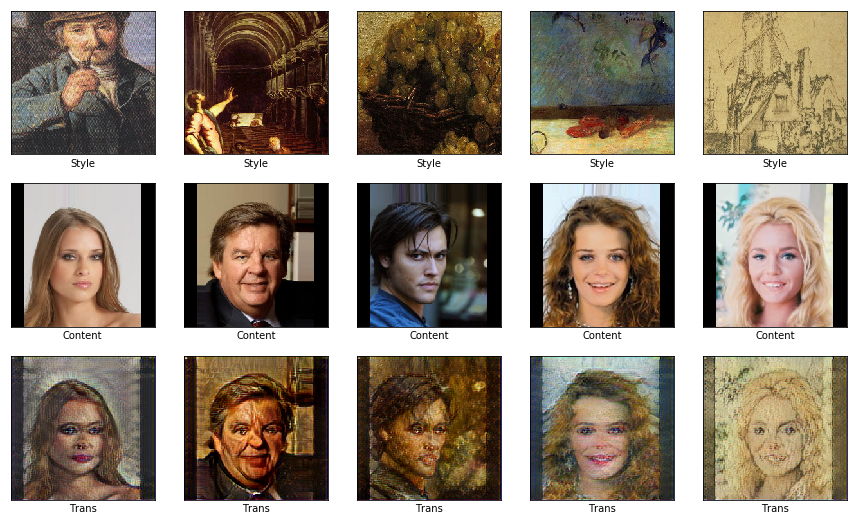

Epoch 10 takes 7062.262940406799 seconds
Epoch 11/30
  375/375 - loss: 549,957.12 - content loss: 262,678.84 - style loss: 287,278.31


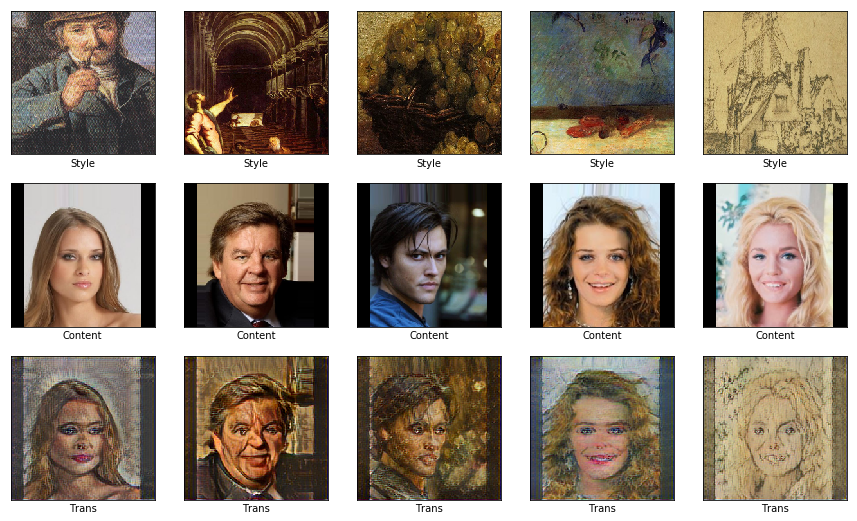

Epoch 11 takes 7116.304100513458 seconds
Epoch 12/30
  375/375 - loss: 536,183.56 - content loss: 257,993.92 - style loss: 278,189.62


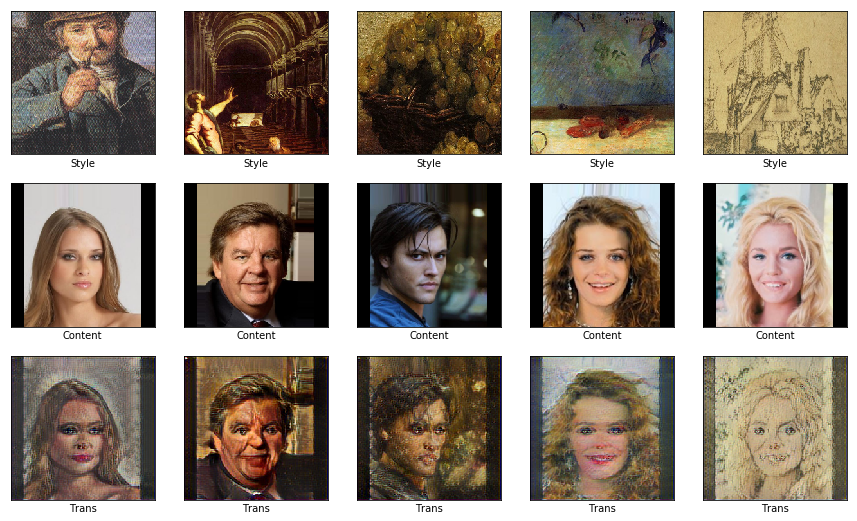

Epoch 12 takes 7029.715433835983 seconds
Epoch 13/30
  375/375 - loss: 518,667.88 - content loss: 252,470.12 - style loss: 266,197.75


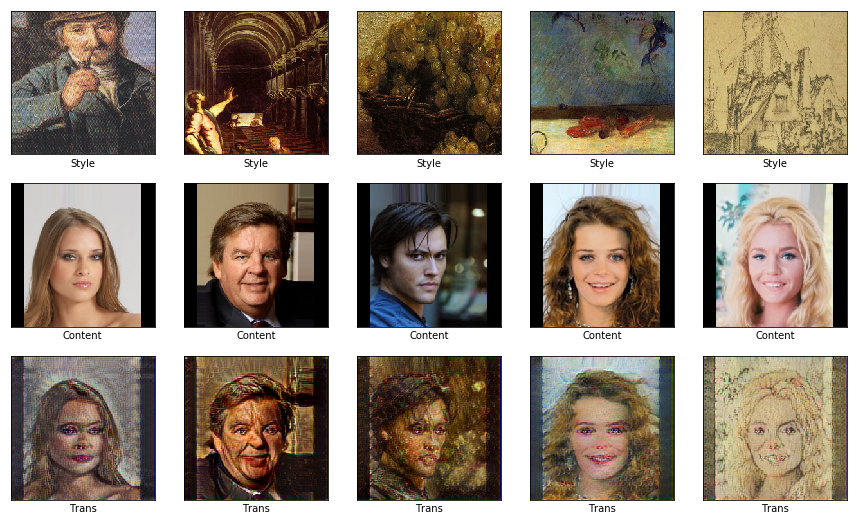

Epoch 13 takes 6988.169792413712 seconds
Epoch 14/30
  375/375 - loss: 518,187.88 - content loss: 250,415.52 - style loss: 267,772.38


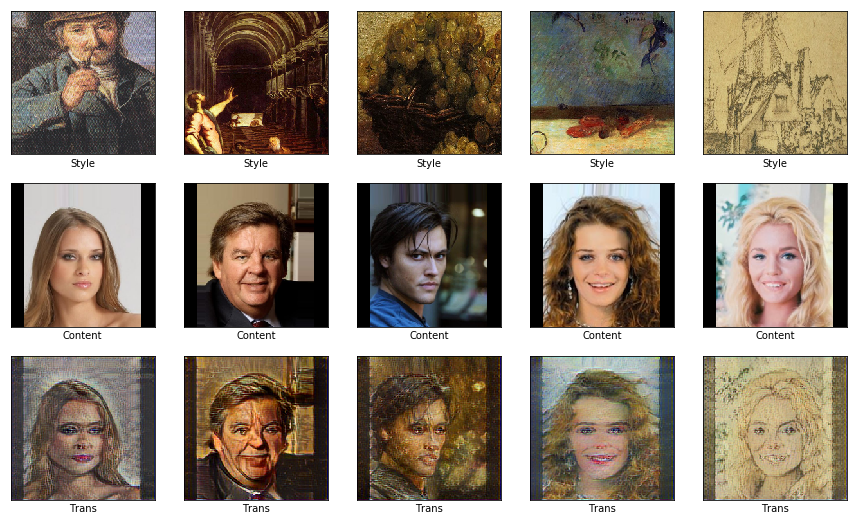

Epoch 14 takes 7002.621532201767 seconds
Epoch 15/30
  375/375 - loss: 520,347.94 - content loss: 248,567.53 - style loss: 271,780.41


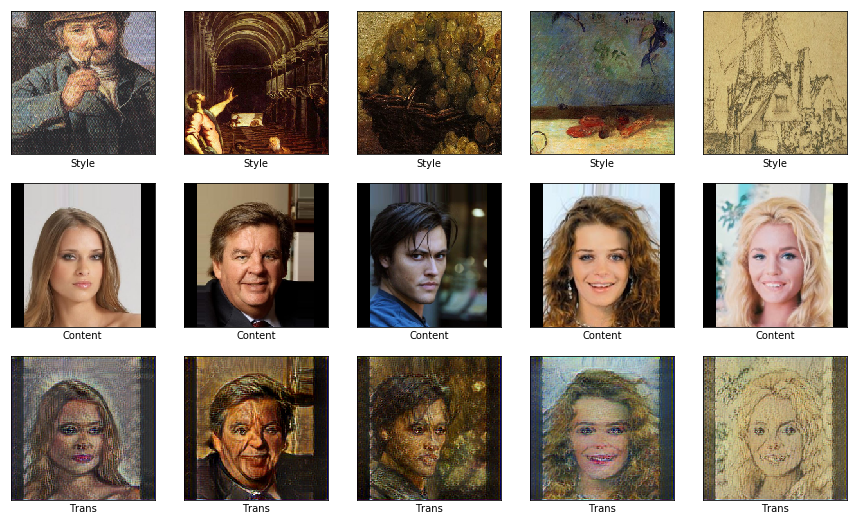

Epoch 15 takes 7091.383859872818 seconds
Epoch 16/30


In [ ]:
train(ds, init_epoch)